In [1]:
import pandas as pd
import numpy as np

In [2]:
%matplotlib inline

In [15]:
import sys
sys.path.append("../code/")
from create_df import read_df
df, dfc, all_homes, appliance_min, national_average = read_df()

In [5]:
st_out = pd.HDFStore("../data/output/fhmm_lbm.h5", mode='r')

In [7]:
to_use_feature = {'dr': 'Monthly+Static',
                 'dw': 'Monthly+Static',
                  'fridge': 'Monthly+Static',
                  'hvac': 'Monthly',
                  'light': 'Static',
                  'wm': 'Static'}

### We need to find the K-Nearest neighbours for each home and then make a prediction based on disaggregated values

In [8]:
import json

In [12]:
appliance="hvac"
f_use="Monthly"
home=6072
json_to_load = "../data/output/sensitivity-numfeatures-allhomes/%s_%s_%d.json" %(appliance, f_use, int(home))
json_data = json.load(open(json_to_load,'r'))

In [13]:
json_data

{u'accuracy': 79.05093724364556,
 u'f': [u'aggregate_6',
  u'aggregate_8',
  u'aggregate_7',
  u'aggregate_5',
  u'p_75',
  u'aggregate_9'],
 u'k': 2}

In [19]:
num_neighbours = json_data['k']
best_feature=json_data['f']
appliance_df = df.ix[all_homes[appliance]]
        
nn = NearestNeighbors(n_neighbors=num_neighbours)
nn.fit(appliance_df[best_feature])

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=1, n_neighbors=2, p=2, radius=1.0)

In [27]:
distances, indices = nn.kneighbors(appliance_df[best_feature].ix[home])

/Users/nipunbatra/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


In [33]:
indices.flatten()[1:]

array([25])

In [16]:
from sklearn.neighbors import NearestNeighbors

In [62]:
lbm_accur = {}
for appliance in ["hvac","fridge","dw","wm","light","dr"]:
#for appliance in ["hvac","fridge","dw"]:
    f_use = to_use_feature[appliance]
    print appliance
    
    if appliance =="hvac":
        start, end = 5, 11
    else:
        start, end = 1, 13
    out_ap = {}
    accuracies = {}
    for home in all_homes[appliance][:]:
        out_ap[home] = {}
        
        json_to_load = "../data/output/sensitivity-numfeatures-allhomes/%s_%s_%d.json" %(appliance, f_use, int(home))
        json_data = json.load(open(json_to_load,'r'))
        num_neighbours = json_data['k']
        f=json_data['f']
        
        appliance_df = df.ix[all_homes[appliance]]
        
        nn = NearestNeighbors(n_neighbors=num_neighbours+1)
        nn.fit(appliance_df[f])
        
        distances, indices = nn.kneighbors(appliance_df[f].ix[home])
        nghrs = appliance_df.index[indices.flatten()[1:]]
        pred = st_out['/%d' %nghrs[0]][appliance]
        for n in nghrs:
            pred+= st_out['/%d' %n][appliance]
        
        pred = pred.div(num_neighbours)
        
        
        for month in range(start, end):
            out_ap[home][month] = {}
            gt = df.ix[home]['%s_%d' %(appliance, month)]
            out_ap[home][month]['gt'] = gt
            out_ap[home][month]['pred'] = pred.ix[month]
        a = pd.DataFrame(out_ap[home]).T
        e = (a['gt']-a['pred']).abs().div(a['gt'])*100
        accur = 100-e
        accur[accur<0] = 0
        accuracies[home] = accur
    lbm_accur[appliance] = pd.DataFrame(accuracies)

/Users/nipunbatra/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/nipunbatra/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/nipunbatra/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a

hvac
fridge

/Users/nipunbatra/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/nipunbatra/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/nipunbatra/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a


dw

/Users/nipunbatra/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/nipunbatra/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/nipunbatra/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a


wm

/Users/nipunbatra/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/nipunbatra/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/nipunbatra/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a


light

/Users/nipunbatra/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/nipunbatra/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/nipunbatra/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a


dr

/Users/nipunbatra/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/nipunbatra/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/nipunbatra/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a

/Users/nipunbatra/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


In [65]:
a = {}
for appliance in ["hvac","dr","dw","fridge","wm"]:
    a[appliance] = pd.DataFrame(lbm_accur[appliance]).mean().mean()

In [77]:
from common_functions import tableau20blind, format_axes

In [80]:
import matplotlib.pyplot as plt

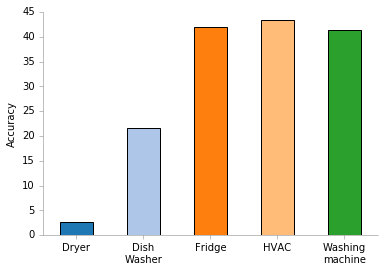

In [84]:
ac_df = pd.Series(a)
ac_df.index = ["Dryer","Dish\nWasher","Fridge","HVAC","Washing\nmachine"]
ac_df.plot(kind="bar", rot=0, color=tableau20blind)
format_axes(plt.gca())
plt.ylabel("Accuracy")
plt.savefig("../results/lbm_disag_neighbours.pdf", bbox_inches="tight")
plt.savefig("../results/lbm_disag_neighbours.png", bbox_inches="tight")

In [75]:
ac_df

dr         2.643439
dw        21.642121
fridge    42.055816
hvac      43.423824
wm        41.421856
dtype: float64

In [52]:
df.ix[home][['hvac_%d' %month for month in range(5, 11)]]

hvac_5     310.352692
hvac_6     283.543427
hvac_7     765.781311
hvac_8     910.076904
hvac_9     634.593872
hvac_10    200.049469
Name: 9934, dtype: float64